In [ ]:
import morecantile
from matplotlib.pyplot import imshow, plot, subplots

from rio_tiler.io import Reader
from rio_tiler.models import ImageData

In [ ]:
src_path = "https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif"
src_path = "D:\\EmDrone\\Lahad Datu\\lahad_datu_cog.tif"

In [ ]:
src_path = "https://njogis-imagery.s3.amazonaws.com/2020/cog/I7D16.tif"
with Reader(src_path) as src:
    info = src.info()
    print("rio-tiler dataset info:")
    print(info.json(exclude_none=True))

rio-tiler dataset info:
{"bounds":[544999.99999999,645000.0,549999.99999999,650000.0],"crs":"http://www.opengis.net/def/crs/EPSG/0/6527","band_metadata":[["b1",{}],["b2",{}],["b3",{}],["b4",{}]],"band_descriptions":[["b1",""],["b2",""],["b3",""],["b4",""]],"dtype":"uint16","nodata_type":"None","colorinterp":["red","green","blue","undefined"],"scales":[1.0,1.0,1.0,1.0],"offsets":[0.0,0.0,0.0,0.0],"driver":"GTiff","count":4,"width":5000,"height":5000,"overviews":[2,4,8,16]}


C:\Users\Nicklim\AppData\Local\Temp\ipykernel_13988\2437532289.py:5: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  print(info.json(exclude_none=True))


['b1', 'b2', 'b3', 'b4']


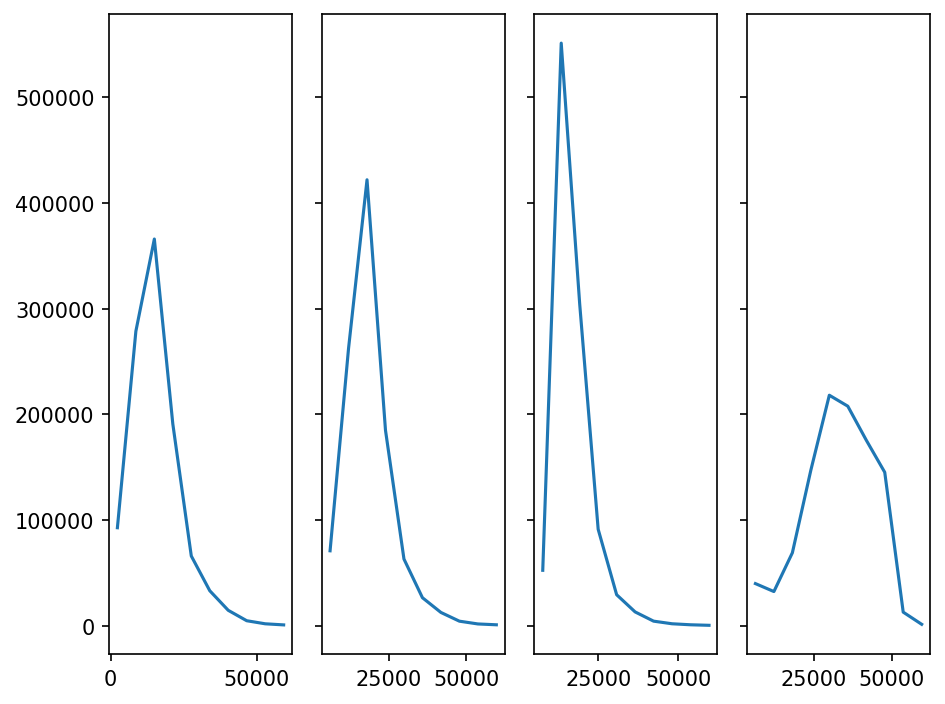

In [ ]:
with Reader(src_path) as src:
    meta = src.statistics()

print(list(meta))

fig, axs = subplots(1, 4, sharey=True, tight_layout=True, dpi=150)
# Red (index 1)
axs[0].plot(meta["b1"].histogram[1][0:-1], meta["b1"].histogram[0])

# Green (index 2)
axs[1].plot(meta["b2"].histogram[1][0:-1], meta["b2"].histogram[0])

# Blue (index 3)
axs[2].plot(meta["b3"].histogram[1][0:-1], meta["b3"].histogram[0])

# Nir (index 3)
axs[3].plot(meta["b4"].histogram[1][0:-1], meta["b4"].histogram[0])

(1, 1024, 1024)
uint16


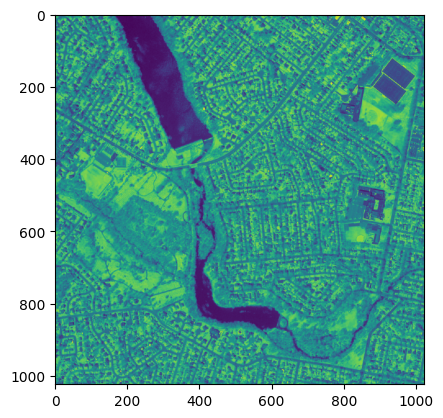

In [ ]:
with Reader(src_path) as src:
    # Return only the third band
    nir_band = src.preview(indexes=4)
    print(nir_band.data.shape)
    print(nir_band.data.dtype)

imshow(nir_band.data_as_image())

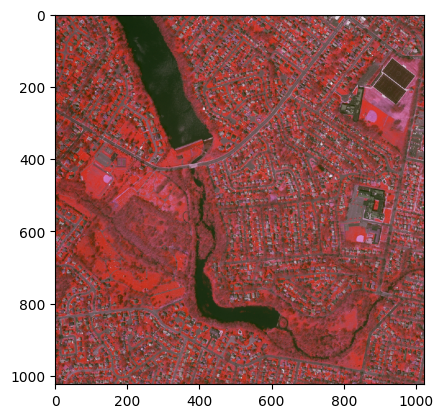

In [ ]:
with Reader(src_path) as src:
    # Return only the third band
    nrg = src.preview(indexes=(4, 3, 1))

    # Data is in Uint16 so we need to rescale
    nrg.rescale(((nrg.data.min(), nrg.data.max()),))

imshow(nrg.data_as_image())

(1, 1024, 1024)
float64
NDVI range:  -0.2865547317109613 0.844091888413218


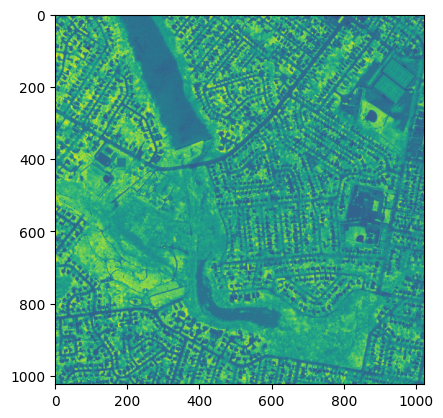

In [ ]:
with Reader(src_path) as src:
    # Apply NDVI band math
    # (NIR - RED) / (NIR + RED)
    ndvi = src.preview(expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)
    print(ndvi.data.dtype)
    print("NDVI range: ", ndvi.data.min(), ndvi.data.max())

ndvi.rescale(in_range=((-1, 1),))
imshow(ndvi.data_as_image())


In [ ]:
with Reader(src_path) as src:
    print(f"Bounds in dataset CRS: {src.bounds}")
    print(f"Bounds WGS84: {src.get_geographic_bounds('epsg:4326')}")
    print(f"MinZoom (WebMercator): {src.minzoom}")
    print(f"MaxZoom (WebMercator): {src.maxzoom}")

# rio-tiler defaults to the WebMercator Grids. The grid definition is provided by the morecantile module
# Docs: https://github.com/developmentseed/morecantile
tms = morecantile.tms.get("WebMercatorQuad")
print(repr(tms))

Bounds in dataset CRS: (544999.99999999, 645000.0, 549999.99999999, 650000.0)
Bounds WGS84: (-74.3095632062702, 40.60399441753999, -74.29151245384847, 40.61775082944064)
MinZoom (WebMercator): 14
MaxZoom (WebMercator): 19
<TileMatrixSet title='Google Maps Compatible for the World' id='WebMercatorQuad' crs='http://www.opengis.net/def/crs/EPSG/0/3857>


In [ ]:
# Get the list of tiles for the COG minzoom
with Reader(src_path) as cog:
    tile_cover = list(
        tms.tiles(*cog.get_geographic_bounds("epsg:4326"), zooms=cog.minzoom)
    )

print(f"Nb of Z{cog.minzoom} Mercator tiles: {len(tile_cover)}")
print(tile_cover)

Nb of Z14 Mercator tiles: 2
[Tile(x=4810, y=6165, z=14), Tile(x=4810, y=6166, z=14)]


(4, 256, 256)
(4, 256, 256)


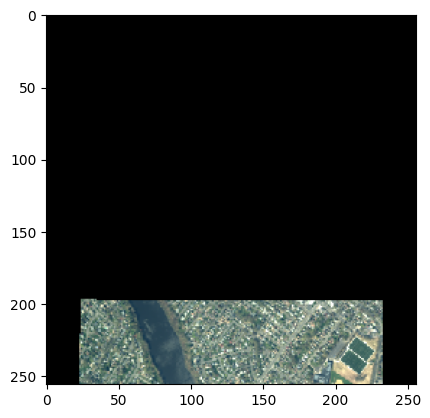

In [ ]:
with Reader(src_path) as src:
    img_1 = src.tile(*tile_cover[0])
    img_1.rescale(((0, 40000),))
    print(img_1.data.shape)

    img_2 = src.tile(*tile_cover[1])
    img_2.rescale(((0, 40000),))

    print(img_2.data.shape)

# Show the first 3 bands (RGB)
imshow(img_1.data_as_image()[:, :, 0:3])

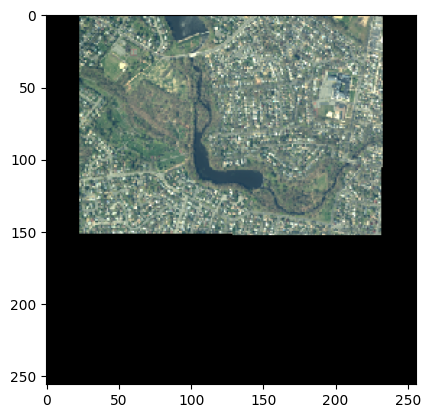

In [ ]:
imshow(img_2.data_as_image()[:, :, 0:3])

(1, 256, 256)


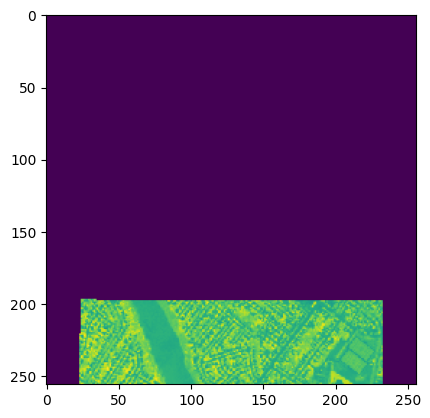

In [ ]:
with Reader(src_path) as src:
    ndvi = src.tile(*tile_cover[0], expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)

ndvi.rescale(in_range=((-1, 1),))
imshow(ndvi.data[0])

Part

In [ ]:
with Reader(src_path) as src:
    # By default `part()` will read the highest resolution. We can limit this by using the `max_size` option.
    img = src.part(
        (-74.30680274963379, 40.60748547709819, -74.29478645324707, 40.61567903099978),
        max_size=1024,
    )
    print("data shape: ", img.data.shape)
    print("bounds: ", img.bounds)
    print("CRS: ", img.crs)

data shape:  (4, 699, 1024)
bounds:  BoundingBox(left=-74.30680274963379, bottom=40.60748547709819, right=-74.29478645324707, top=40.61567903099978)
CRS:  EPSG:4326


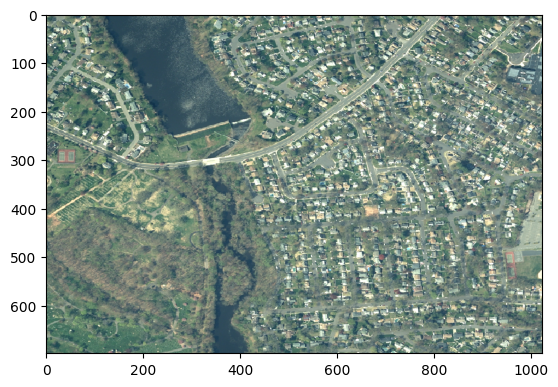

In [ ]:
img.rescale(((0, 40000),))

imshow(img.data_as_image()[:, :, 0:3])

# Read the pixel value for a specific lon/lat coordinate

In [ ]:
with Reader(src_path) as src:
    pt = src.point(-74.30680274963379, 40.60748547709819)

    print("RGB-Nir values:")
    print([(b, pt.data[ii]) for ii, b in enumerate(pt.band_names)])

    print("NDVI values:")
    ndvi = pt.apply_expression("(b4-b1)/(b4+b1)")
    print([(b, ndvi.data[ii]) for ii, b in enumerate(ndvi.band_names)])

RGB-Nir values:
[('b1', np.uint16(11002)), ('b2', np.uint16(15954)), ('b3', np.uint16(14478)), ('b4', np.uint16(32050))]
NDVI values:
[('(b4-b1)/(b4+b1)', np.float64(0.48889714763541764))]


In [ ]:
feat = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-74.30384159088135, 40.614245638811646],
                [-74.30680274963379, 40.61121586776988],
                [-74.30590152740477, 40.608967884350946],
                [-74.30272579193115, 40.60748547709819],
                [-74.29875612258911, 40.60786015456402],
                [-74.2960524559021, 40.61012446497514],
                [-74.29478645324707, 40.61390357476733],
                [-74.29882049560547, 40.61515780103489],
                [-74.30294036865233, 40.61567903099978],
                [-74.3035626411438, 40.61502749290829],
                [-74.30384159088135, 40.614245638811646],
            ]
        ],
    },
}

In [ ]:
with Reader(src_path) as src:
    # we use the feature to define the bounds and the mask
    # but we use `dst_crs` options to keep the projection from the input dataset
    # By default `feature()` will read the highest resolution. We can limit this by using the `max_size` option.
    img = src.feature(feat, dst_crs=src.crs, max_size=1024)
    print("data shape: ", img.data.shape)
    print("bounds: ", img.bounds)
    print("CRS: ", img.crs)

data shape:  (4, 917, 1024)
bounds:  BoundingBox(left=np.float64(545757.1269694079), bottom=np.float64(646262.0947405763), right=np.float64(549099.8472835454), top=np.float64(649254.4633358676))
CRS:  EPSG:6527


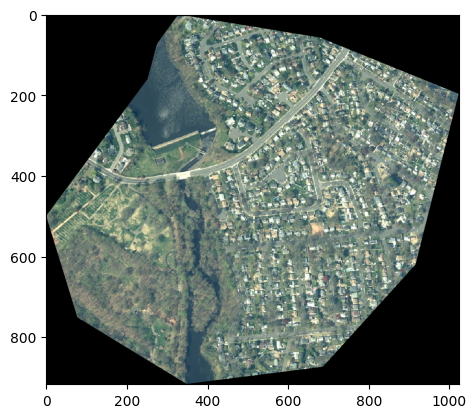

In [ ]:
img.rescale(((0, 40000),))
imshow(img.data_as_image()[:, :, 0:3])